# Compare two datasets

Let's compare two pedestrian evaluations with different method: field count vs. cnn count. 

In [68]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

## Get NYC field count 

metadata - http://www.nyc.gov/html/dot/downloads/pdf/bi-annual-ped-count-readme.pdf

It has three different sorts of count
* \_am: weekday morning (7-9am)
* \_pm: weekday afternoon (4-7pm)
* \_md: weekend midday (12-2pm)

In [63]:
query = ("https://data.cityofnewyork.us/resource/cqsj-cfgu.json")
df_field = pd.read_json(query)
df_field.head()

,borough,from_,index,loc,may07_am,may07_d,may07_d2,may07_md,may07_pm,may08_am,...,sept13_md,sept13_pm,sept14_am,sept14_d,sept14_d2,sept14_md,sept14_pm,street,the_geom,to
0,Bronx,West 231st Street,N,1,1189,5/10/2007,5/5/2007,2508,4094,802,...,3008,4590,1450,09/04/14,09/06/14,2996,4646,Broadway,"{'type': 'Point', 'coordinates': [-73.90459140...",Naples Terrace
1,Bronx,Grand Concourse,Y,2,1511,5/10/2007,5/5/2007,1971,3184,1136,...,1832,3890,1949,09/11/14,09/13/14,2388,4435,East 161st Street,"{'type': 'Point', 'coordinates': [-73.92188432...",Sheridan Avenue
2,Bronx,Valentine Avenue,Y,3,1832,5/10/2007,5/5/2007,14391,12311,1061,...,8241,10613,2752,09/04/14,09/06/14,8266,10408,East Fordham Road,"{'type': 'Point', 'coordinates': [-73.89535781...",Tiebout Avenue
3,Bronx,Bainbridge Avenue,N,4,764,5/10/2007,5/5/2007,1798,2673,2102,...,1914,3660,2382,09/04/14,09/06/14,1339,3425,East Gun Hill Road,"{'type': 'Point', 'coordinates': [-73.87892467...",Rochambeau Avenue
4,Bronx,Prospect Avenue,N,5,650,5/10/2007,5/5/2007,2334,2538,553,...,2805,3488,1019,09/04/14,09/06/14,2366,3184,East Tremont Avenue,"{'type': 'Point', 'coordinates': [-73.88956389...",Clinton Avenue


### Add aggregated columns

In [96]:
df_field['avg_field_all'] = df_field.filter(regex='_am|_md|_pm').mean(axis=1)
df_field['avg_field_md'] = df_field.filter(regex='_md').mean(axis=1)
df_field['avg_field_am'] = df_field.filter(regex='_am').mean(axis=1)
df_field['avg_field_pm'] = df_field.filter(regex='_pm').mean(axis=1)

### relationship between all, md, am, pm
No big difference between md, am, and pm. 'all' seems to represent all other three well.

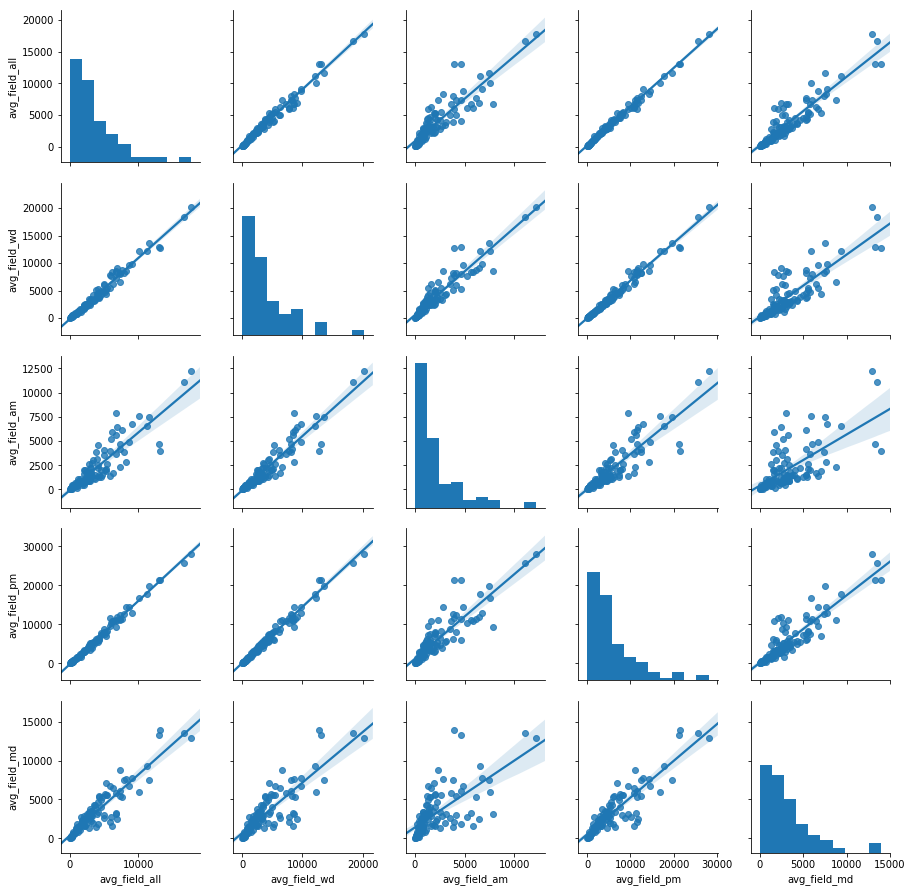

In [104]:
sns.pairplot(
    df_field[['avg_field_all', 'avg_field_wd', 'avg_field_am', 'avg_field_pm', 'avg_field_md']],
    kind='reg'
)

## Count from CNN

The result dataset includes the detection 'probability' of all identified person in the street view image of which score is higher than 0.05. From this dataset, we need to an aggregated estimation of a location's pedestrian volume.

We are going to test two different ways of aggregation.

1. Count the number of identified person 
  - count the number of people detected with a high probability (say, probability is greater than 0.7) to remove the effect of falsely detected person.

2. Sum of all 'person' scores at a location
  - sum all scores of identified person since 1) setting another threshold is arbitrary and 2) effect of detections with low score is low.

In [165]:
# read result dataset
df_cnn = pd.read_csv("../data/dataframe/nyc-cnn-exp.csv")[['lid', 'score']]

In [176]:
df_cnn_agg = pd.DataFrame()
# sum all scores
df_cnn_agg['cnn_score_sum'] = df_cnn.groupby('lid')\
    .agg('sum')['score']
# count where score > 0.7
df_cnn_agg['cnn_score_count'] = df_cnn[df_cnn.score > 0.7]\
    .groupby('lid').count()
df_cnn_agg = df_cnn_agg.fillna(0)  # no count 
df_cnn_agg.tail()

,cnn_score_sum,cnn_score_count
lid,,
109,2.195085,1.0
110,4.195085,0.0
111,4.066106,2.0
112,0.717181,0.0
113,1.182972,0.0


In [174]:
df = df_field.join(df_cnn_agg)[['avg_field_all',
                                'cnn_score_sum',
                                'cnn_score_count'
                               ]]

## count above 0.7 

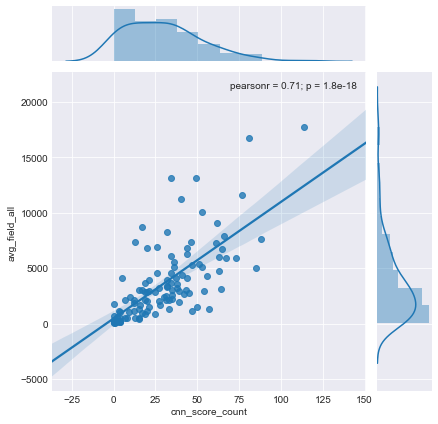

In [194]:
sns.set_style("darkgrid")
sns.jointplot(x="cnn_score_count", y="avg_field_all", data=df, kind="reg")
plt.show()

## sum all probabilities

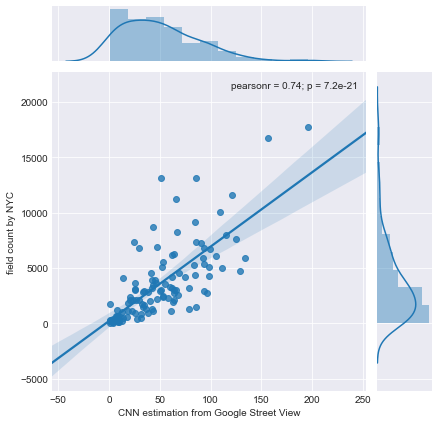

In [205]:
g= sns.jointplot(x="cnn_score_sum", 
              y="avg_field_all", 
              data=df, kind="reg")
plt.xlabel("CNN estimation from Google Street View")
plt.ylabel("field count by NYC")
plt.show()